# 13 – Health Inequalities: Measuring the Gradient

**Learning Objectives:**
- Understand the Index of Multiple Deprivation (IMD) and how it is constructed
- Distinguish between life expectancy and healthy life expectancy
- Understand the distinction between absolute and relative measures of inequality
- Calculate the Slope Index of Inequality (SII) and Relative Index of Inequality (RII)
- Interpret concentration curves and concentration indices
- Apply these measures to dietary intake and nutrition-related health outcomes

---

## 1. Introduction: Why Measure Inequalities?

Average population health can improve while inequalities widen. Consider:

- Life expectancy in England increased for all groups between 2001-2019
- But the gap between the most and least deprived areas *also* increased

If we only track averages, we miss this divergence. Health inequality metrics help us:

1. **Describe** the current distribution of health across social groups
2. **Monitor** whether policies are reducing or widening gaps
3. **Target** interventions toward those in greatest need

### The Marmot Curve

Health follows a **gradient** — it's not simply that the poorest are unhealthy. Each step up the socioeconomic ladder is associated with better health outcomes.

## 2. Setup

In [2]:
# ============================================================
# Bootstrap cell (works both locally and in Colab)
# ============================================================

import os
import sys
import pathlib
import subprocess

REPO_URL = "https://github.com/ggkuhnle/phn-epi.git"
REPO_DIR = "phn-epi"

cwd = pathlib.Path.cwd()

if (cwd / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd
elif (cwd.parent / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd.parent
else:
    repo_root = cwd / REPO_DIR
    if not repo_root.is_dir():
        print(f"Cloning repository from {REPO_URL} ...")
        subprocess.run(["git", "clone", REPO_URL, str(repo_root)], check=True)
    else:
        print(f"Using existing repository at {repo_root}")
    os.chdir(repo_root)
    repo_root = pathlib.Path.cwd()

scripts_dir = repo_root / "scripts"
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

print(f"Repository root: {repo_root}")
print("Bootstrap completed successfully.")

Repository root: /Users/gunter/Documents/fb2nep-epi
Bootstrap completed successfully.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from ipywidgets import FloatSlider, VBox, Output
import ipywidgets as widgets
from IPython.display import display, HTML
from pathlib import Path

from epi_utils import (
    calculate_sii, calculate_rii, calculate_concentration_index,
    plot_concentration_curve, INEQUALITY_EXAMPLE_DATA
)

# ————— Paths —————
DATA_DIR = Path("../data")
IMD_CSV = DATA_DIR / "IoD2019_ranks.csv"
LE_CSV  = DATA_DIR / "le_imd.csv"

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 3. The Index of Multiple Deprivation (IMD)

### What is the IMD?

The **Index of Multiple Deprivation (IMD)** is the official measure of relative deprivation for small areas in England. It ranks every **Lower Layer Super Output Area (LSOA)** — approximately 32,844 areas, each containing around 1,500 people.

### The Seven Domains of Deprivation

| Domain | Weight | What it measures |
|--------|--------|------------------|
| **Income** | 22.5% | Proportion of population on low income |
| **Employment** | 22.5% | Proportion involuntarily excluded from work |
| **Education** | 13.5% | Lack of attainment and skills |
| **Health & Disability** | 13.5% | Premature death and impairment |
| **Crime** | 9.3% | Risk of victimisation |
| **Barriers to Housing** | 9.3% | Physical and financial accessibility |
| **Living Environment** | 9.3% | Indoor and outdoor environment quality |

![IMD Domains](../_assets/imd_domains.png)

(https://assets.publishing.service.gov.uk/media/5d8e26f6ed915d5570c6cc55/IoD2019_Statistical_Release.pdf)

### Important Notes

1. **Relative, not absolute**: IMD ranks areas relative to each other
2. **Area-level, not individual**: Not everyone in a deprived area is deprived (ecological fallacy)
3. **England only**: Scotland, Wales, and Northern Ireland have separate indices

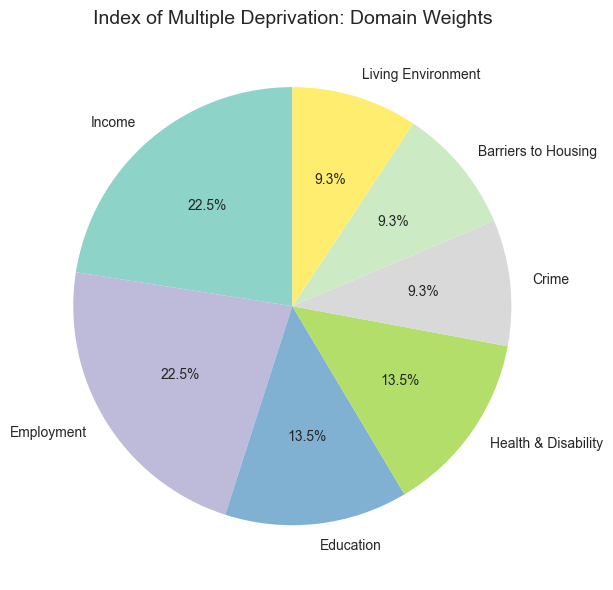

Note: Income and Employment together account for 45% of the overall IMD.


In [5]:
# IMD domain weights visualisation
imd_domains = pd.DataFrame({
    'Domain': ['Income', 'Employment', 'Education', 'Health & Disability', 
               'Crime', 'Barriers to Housing', 'Living Environment'],
    'Weight (%)': [22.5, 22.5, 13.5, 13.5, 9.3, 9.3, 9.3]
})

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, 7))
ax.pie(imd_domains['Weight (%)'], labels=imd_domains['Domain'],
       autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Index of Multiple Deprivation: Domain Weights', fontsize=14)
plt.tight_layout()
plt.show()

print("Note: Income and Employment together account for 45% of the overall IMD.")

### Exploring IMD Maps

**Key Resources:**

- [**ONS Interactive IMD Map**](https://dclgapps.communities.gov.uk/imd/iod_index.html) — Explore deprivation by LSOA
- [**CDRC IMD Geodata Pack**](https://data.cdrc.ac.uk/dataset/index-multiple-deprivation-imd) — Download IMD data
- [**PHE Fingertips**](https://fingertips.phe.org.uk/) — Health outcomes by deprivation

In [6]:
# Display link to interactive IMD map
display(HTML('''
<div style="text-align: center; padding: 20px; background-color: #f5f5f5; border-radius: 10px;">
    <h3>Index of Multiple Deprivation 2019 - England</h3>
    <p><a href="https://dclgapps.communities.gov.uk/imd/iod_index.html" target="_blank">
        Click here to explore the interactive IMD map →
    </a></p>
    <p style="font-size: 12px; color: #666;">Source: MHCLG (2019)</p>
</div>
'''))

In [19]:

# ————— Load the full CSV —————
df = pd.read_csv(IMD_CSV)

# ————— Extract LA-level summary —————
# Select only the columns we need
df_la = (
    df[[
        "Local Authority District name (2019)",
        "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)",
        "Index of Multiple Deprivation (IMD) Score"
    ]]
    .dropna()
    # Rename for convenience
    .rename(columns={
        "Local Authority District name (2019)": "Local Authority",
        "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "IMD Rank",
        "Index of Multiple Deprivation (IMD) Score": "IMD Score"
    })
    .drop_duplicates()
    # Sort so rank=1 is top
    .sort_values("IMD Rank")
    .reset_index(drop=True)
)

print("Loaded IMD 2019 LA ranks:")

# 
# Most and least deprived local authorities
la_deprivation = pd.DataFrame({
    'Local Authority': ['Blackpool', 'Knowsley', 'Hull', 'Middlesbrough', 'Liverpool',
                        'Hart', 'Wokingham', 'Surrey Heath', 'S. Cambridgeshire', 'Elmbridge'],
    'Rank (of 317)': [1, 2, 3, 4, 5, 317, 316, 315, 314, 313],
    'Category': ['Most deprived'] * 5 + ['Least deprived'] * 5
})

print("Most and Least Deprived Local Authorities (IMD 2019)")
print("=" * 60)
display(la_deprivation)

Loaded IMD 2019 LA ranks:
Most and Least Deprived Local Authorities (IMD 2019)


,Local Authority,Rank (of 317),Category
0,Blackpool,1,Most deprived
1,Knowsley,2,Most deprived
2,Hull,3,Most deprived
3,Middlesbrough,4,Most deprived
4,Liverpool,5,Most deprived
5,Hart,317,Least deprived
6,Wokingham,316,Least deprived
7,Surrey Heath,315,Least deprived
8,S. Cambridgeshire,314,Least deprived
9,Elmbridge,313,Least deprived


Most local authorities cluster across the distribution; only a few lie at the extremes. So where are we?

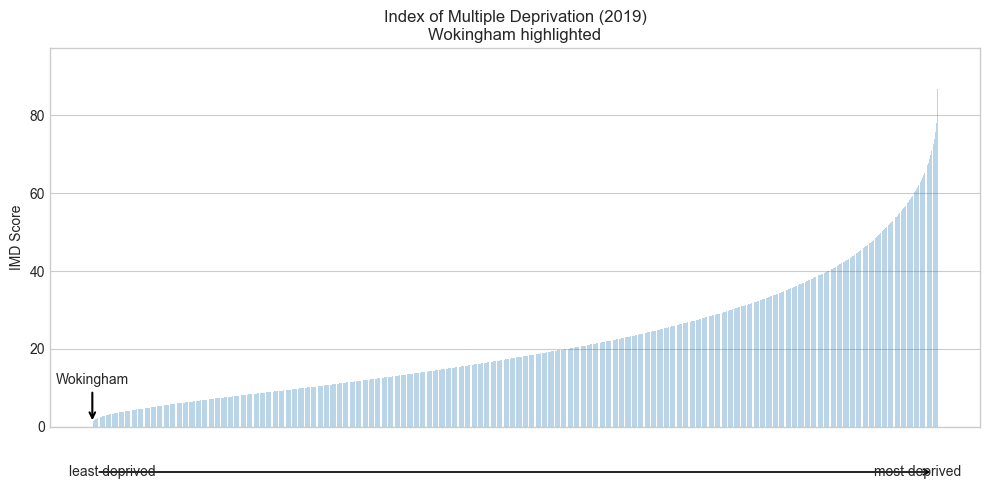

In [24]:
df_plot = df_la.sort_values("IMD Score").reset_index(drop=True)



# Boolean mask for Wokingham
is_wokingham = df_plot["Local Authority"] == "Wokingham"

# Locate Wokingham
wk_idx = df_plot.index[df_plot["Local Authority"] == "Wokingham"][0]
wk_score = df_plot.loc[wk_idx, "IMD Score"]

# X positions (one per authority)
x = np.arange(len(df_plot))

plt.figure(figsize=(10, 5))

# All authorities (background)
plt.bar(
    x,
    df_plot["IMD Score"],
    alpha=0.3
)

# Arrow pointing to Wokingham
plt.annotate(
    "Wokingham",
    xy=(wk_idx, wk_score),
    xytext=(wk_idx, wk_score + 10),  # vertical offset
    arrowprops=dict(
        arrowstyle="->",
        linewidth=1.5
    ),
    ha="center"
)

plt.annotate(
    "",
    xy=(0.95, -0.12),
    xytext=(0.05, -0.12),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", linewidth=1.2),
)

# End labels
plt.text(
    0.02, -0.12, "least deprived",
    transform=plt.gca().transAxes,
    ha="left", va="center"
)

plt.text(
    0.98, -0.12, "most deprived",
    transform=plt.gca().transAxes,
    ha="right", va="center"
)

# Axis handling
plt.xticks([])  # remove unreadable labels
plt.ylabel("IMD Score")
plt.title("Index of Multiple Deprivation (2019)\nWokingham highlighted")

plt.tight_layout()
plt.show()

## 4. Life Expectancy vs Healthy Life Expectancy

### Definitions

- **Life expectancy (LE)**: Average years a newborn would live if current mortality rates persist
- **Healthy life expectancy (HLE)**: Average years expected in "good" or "very good" health

### The Double Burden of Deprivation

The gap between LE and HLE represents **years lived in poor health**. In deprived areas, people:
1. Die younger
2. Spend a larger proportion of their shorter lives in poor health

In [42]:
le_hle_data = pd.read_csv(LE_CSV)


# Sort in the natural order (most deprived -> least deprived)
le_hle_data = le_hle_data.sort_values("IMD_decile").reset_index(drop=True)

print("Life Expectancy and Healthy Life Expectancy by IMD Decile (England, 2020–2022)")
display(le_hle_data[["IMD_decile", "LE_male", "HLE_male", "LE_female", "HLE_female"]])

Life Expectancy and Healthy Life Expectancy by IMD Decile (England, 2020–2022)


,IMD_decile,LE_male,HLE_male,LE_female,HLE_female
0,1,72.58,51.13,77.66,50.54
1,2,74.92,55.64,79.58,55.01
2,3,76.56,58.79,81.01,59.28
3,4,77.94,60.09,82.09,61.26
4,5,79.09,62.61,83.00,63.05
5,6,80.06,64.20,83.65,64.38
6,7,80.64,65.17,84.17,66.37
7,8,81.36,66.77,84.63,68.01
8,9,81.93,68.26,85.18,68.70
9,10,82.98,70.09,86.08,70.16


The State Pension Age is 66 (rising to 67 by 2028). In the most deprived areas, men reach their HLE **14.5 years BEFORE** pension age.

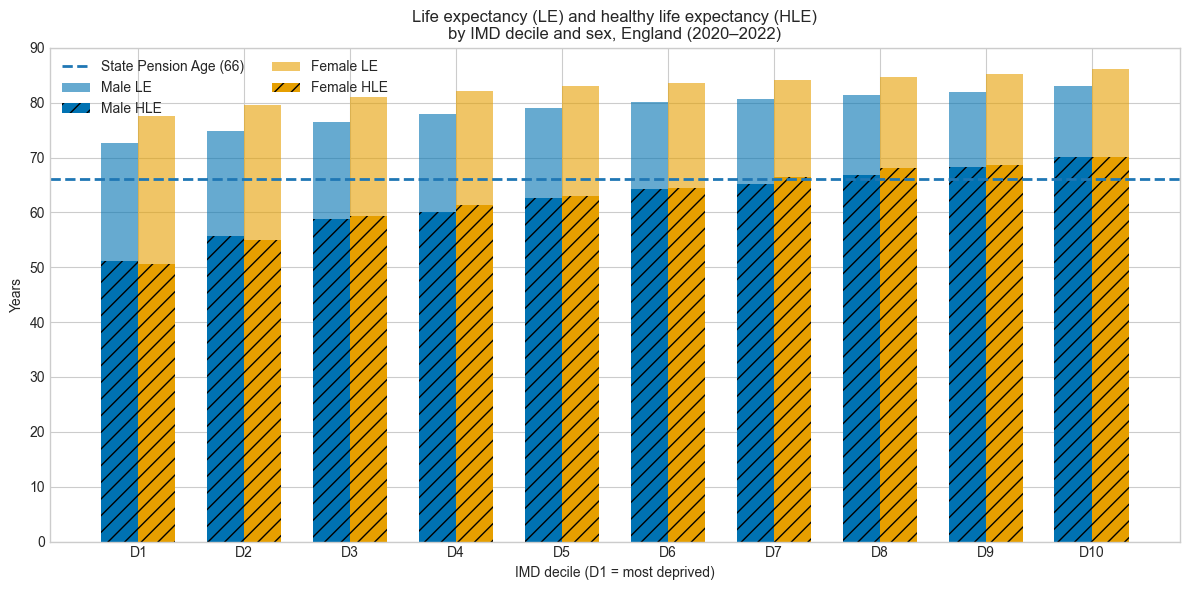

In [51]:
pension_age = 66

# X positions
x = np.arange(len(le_hle_data))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Colour-blind safe palette (Okabe–Ito)
male_colour = "#0072B2"    # blue
female_colour = "#E69F00"  # orange

# ---- Male bars ----
ax.bar(
    x - width/2,
    le_hle_data["LE_male"],
    width,
    label="Male LE",
    color=male_colour,
    alpha=0.6,
    hatch=""
)
ax.bar(
    x - width/2,
    le_hle_data["HLE_male"],
    width,
    label="Male HLE",
    color=male_colour,
    hatch="//"
)

# ---- Female bars ----
ax.bar(
    x + width/2,
    le_hle_data["LE_female"],
    width,
    label="Female LE",
    color=female_colour,
    alpha=0.6,
    hatch=""
)
ax.bar(
    x + width/2,
    le_hle_data["HLE_female"],
    width,
    label="Female HLE",
    color=female_colour,
    hatch="//"
)

# ---- Axes and labels ----
ax.set_xticks(x)
ax.set_xticklabels([f"D{d}" for d in le_hle_data["IMD_decile"]])
ax.set_xlabel("IMD decile (D1 = most deprived)")
ax.set_ylabel("Years")
ax.set_title(
    "Life expectancy (LE) and healthy life expectancy (HLE)\n"
    "by IMD decile and sex, England (2020–2022)"
)
ax.set_ylim(0, 90)

# ---- Pension age line ----
ax.axhline(
    y=pension_age,
    linestyle="--",
    linewidth=2,
    label=f"State Pension Age ({pension_age})"
)

# ---- Legend ----
ax.legend(ncol=2, loc="upper left")



plt.tight_layout()
plt.show()


## 5. Measuring Inequality: SII and RII

### Slope Index of Inequality (SII)

The SII fits a regression across the entire gradient, using all data points.

In [ ]:
# Obesity prevalence by deprivation
obesity_data = pd.DataFrame({
    'quintile': ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
    'population_share': [0.20, 0.20, 0.20, 0.20, 0.20],
    'obesity_prevalence': [0.34, 0.30, 0.27, 0.24, 0.20]
})

def calculate_sii_manual(data, outcome_col, pop_share_col='population_share'):
    data = data.copy()
    data['cum_pop'] = data[pop_share_col].cumsum()
    data['cum_pop_lag'] = data['cum_pop'].shift(1, fill_value=0)
    data['ridit'] = (data['cum_pop'] + data['cum_pop_lag']) / 2
    slope, intercept, r_value, p_value, _ = stats.linregress(data['ridit'], data[outcome_col])
    return {'sii': slope, 'intercept': intercept, 'data_with_ridit': data}

sii_result = calculate_sii_manual(obesity_data, 'obesity_prevalence')
print(f"SII for obesity: {sii_result['sii']:.3f}")
print(f"\nThis means obesity prevalence decreases by {abs(sii_result['sii']):.1%}")
print(f"moving from most to least deprived.")

In [ ]:
# Visualise SII
fig, ax = plt.subplots(figsize=(10, 6))
data = sii_result['data_with_ridit']
ax.scatter(data['ridit'], data['obesity_prevalence'], s=100, color='steelblue', zorder=5)
x_line = np.linspace(0, 1, 100)
y_line = sii_result['intercept'] + sii_result['sii'] * x_line
ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'SII = {sii_result["sii"]:.3f}')
for i, row in data.iterrows():
    ax.annotate(row['quintile'], (row['ridit'], row['obesity_prevalence']),
                textcoords="offset points", xytext=(0, 10), ha='center')
ax.set_xlabel('Ridit Score (0 = most deprived, 1 = least deprived)')
ax.set_ylabel('Obesity Prevalence')
ax.set_title('Slope Index of Inequality for Obesity')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

## 6. Discussion Questions

1. **IMD limitations**: Why might the IMD be a poor measure of individual deprivation?

2. **LE vs HLE**: Why is the HLE gap larger than the LE gap? What does this imply for pension policy?

3. **Proportionate universalism**: How might you measure whether a dietary intervention follows this principle?

## 7. Exercises

### Exercise 1: Explore IMD in Your Area

1. Go to the [ONS IMD Explorer](https://dclgapps.communities.gov.uk/imd/iod_index.html)
2. Find your home area (or Reading)
3. Note the IMD decile and domain scores

In [ ]:
# Record your findings
my_area = {
    'Area name': '',
    'IMD Decile': None,
    'Most deprived domain': ''
}

---

## Summary

- **IMD** combines seven domains to rank areas by deprivation
- **Healthy life expectancy** reveals larger inequality gaps than total LE
- The "double burden" means deprived populations live shorter lives AND more years in poor health
- **SII** measures absolute inequality; **RII** expresses it relatively

## Key Resources

- [ONS IMD Interactive Map](https://dclgapps.communities.gov.uk/imd/iod_index.html)
- [PHE Fingertips](https://fingertips.phe.org.uk/)
- [ONS Health State Life Expectancy](https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/healthandlifeexpectancies)

## References

- MHCLG (2019). English Indices of Deprivation.
- Marmot M (2010). Fair Society, Healthy Lives.
- Marmot M (2020). Health Equity in England: The Marmot Review 10 Years On.